### Goal: change variables encoding to see if accuracy can be improved
- Different clustering of <code>Fare</code>
- Try dropping <code>Cabin</code>?
- One-hot encoding <code>Sex</code> into 2 columns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('clean_data.csv', index_col='Unnamed: 0')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Tuning <code>Fare</code> (conclusion: no improvement 🥲)

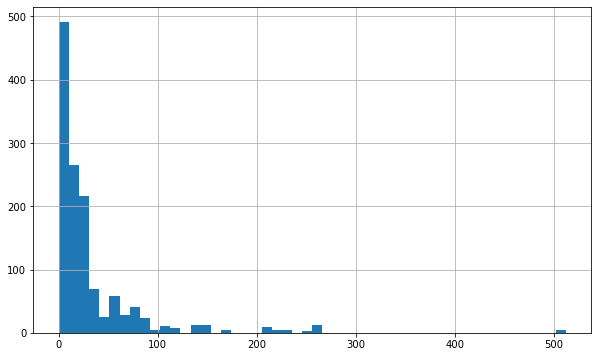

In [3]:
fig = plt.figure(figsize=(10, 6))
plt.hist(data.Fare.values, bins=50)
plt.grid(True)
plt.show()

In [4]:
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
fare = data.Fare.values.reshape(-1, 1)
params = range(3, 16)
param_grid = ParameterGrid({'n_clusters': params})
best_score = -1
kmeans_model = KMeans()
silhouette_scores = []
for p in param_grid:
    kmeans_model.set_params(**p)
    kmeans_model.fit(fare)
    ss = silhouette_score(fare, kmeans_model.labels_)
    silhouette_scores += [ss]
    print('Parameter: {}, Score: {}'.format(p, ss))
    if ss > best_score:
        best_score = ss
        best_grid = p

Parameter: {'n_clusters': 3}, Score: 0.7690165991511371
Parameter: {'n_clusters': 4}, Score: 0.7652973885346566
Parameter: {'n_clusters': 5}, Score: 0.7595185403828791
Parameter: {'n_clusters': 6}, Score: 0.7160151664623494
Parameter: {'n_clusters': 7}, Score: 0.7194898799342638
Parameter: {'n_clusters': 8}, Score: 0.7219618241418816
Parameter: {'n_clusters': 9}, Score: 0.7262827364285757
Parameter: {'n_clusters': 10}, Score: 0.6829663367892026
Parameter: {'n_clusters': 11}, Score: 0.6861036543662523
Parameter: {'n_clusters': 12}, Score: 0.6837836901216036
Parameter: {'n_clusters': 13}, Score: 0.6819291473635908
Parameter: {'n_clusters': 14}, Score: 0.6773923999275064
Parameter: {'n_clusters': 15}, Score: 0.6860879776644537


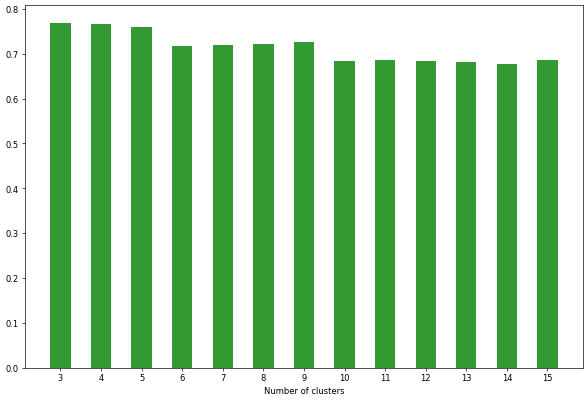

In [6]:
plt.figure(figsize=(12, 8), dpi=60)
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='g', width=0.5, alpha=0.8)
plt.xticks(range(len(silhouette_scores)), list(params))
plt.xlabel('Number of clusters')
plt.show()

So there's no better clustering than 3 clusters.

### Tuning <code>Sex</code> (conclusion: I was originally using 0 & 1 so one-hot encoding is exactly the same thing, I forgot 😓)

In [23]:
df = pd.read_csv('final.csv', index_col='Unnamed: 0')
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin
0,0,2,0,1,1,1
1,1,0,1,1,2,1
2,1,2,1,1,1,1
3,1,0,1,1,2,1
4,0,2,0,1,1,1


In [24]:
# Current encoding: 0 - male, 1 - female
df.loc[df.Sex == 0, 'Sex_m'] = 1
df.loc[df.Sex == 1, 'Sex_m'] = 0
df.loc[df.Sex == 0, 'Sex_f'] = 0
df.loc[df.Sex == 1, 'Sex_f'] = 1

df.Sex_m = df.Sex_m.astype(int)
df.Sex_f = df.Sex_f.astype(int)

In [25]:
df

,Survived,Pclass,Sex,Age,Fare,Cabin,Sex_m,Sex_f
0,0,2,0,1,1,1,1,0
1,1,0,1,1,2,1,0,1
2,1,2,1,1,1,1,0,1
3,1,0,1,1,2,1,0,1
4,0,2,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...
1301,0,2,0,1,1,1,1,0
1302,1,0,1,1,2,1,0,1
1303,0,2,0,1,1,1,1,0
1304,0,2,0,1,1,1,1,0


### Model evaluation: dropping <code>Cabin</code>

In [26]:
to_drop = ['Sex', 'Cabin']
df_nocabin = df.drop(columns=to_drop, axis=1)

In [27]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import networkx as nx
from sklearn.metrics import accuracy_score
import cv

Finding Elimination Order: : 100%|██████████| 4/4 [01:05<00:00, 16.37s/it]


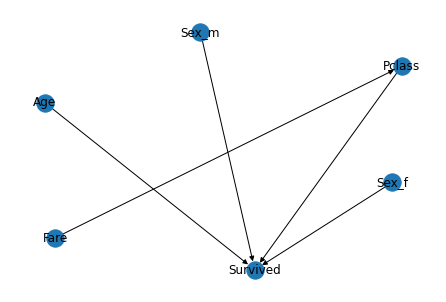

In [28]:
model = BayesianModel([('Fare', 'Pclass'),
                       ('Pclass', 'Survived'),
                       ('Age', 'Survived'),
                       ('Sex_f', 'Survived'),
                       ('Sex_m', 'Survived')])
nx.draw(model, with_labels=True)

In [29]:
scores = cv.cross_val(model, df_nocabin, 10, target="Survived")

100%|██████████| 23/23 [00:00<00:00, 741.22it/s]


In [30]:
print('Mean score:', np.mean(scores))
scores

Mean score: 0.8468115091015853


[0.9007633587786259,
 0.8244274809160306,
 0.8769230769230769,
 0.8473282442748091,
 0.8076923076923077,
 0.8549618320610687,
 0.8,
 0.8549618320610687,
 0.8384615384615385,
 0.8625954198473282]

In [31]:
from pgmpy.inference import VariableElimination
model_infer = VariableElimination(model)

In [32]:
q = model_infer.query(variables=['Survived'], evidence={'Sex_f': 0})
print(q)

Eliminating: Fare: 100%|██████████| 4/4 [00:00<00:00, 356.73it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.7258 |
+-------------+-----------------+
| Survived(1) |          0.2742 |
+-------------+-----------------+


### Model evaluation: keeping <code>Cabin</code>

In [33]:
to_drop = ['Sex']
df_cabin = df.drop(columns=to_drop, axis=1)

Finding Elimination Order: : 100%|██████████| 4/4 [00:53<00:00, 13.44s/it]


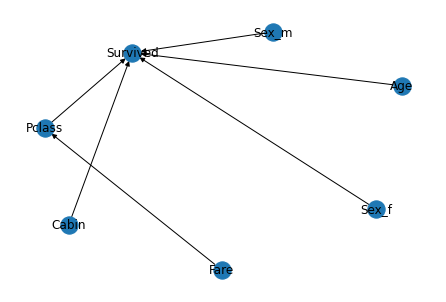

In [34]:
model2 = BayesianModel([('Fare', 'Pclass'),
                        ('Pclass', 'Survived'),
                        ('Age', 'Survived'),
                        ('Sex_f', 'Survived'),
                        ('Sex_m', 'Survived'),
                        ('Cabin', 'Survived')])
nx.draw(model2, with_labels=True)

In [35]:
scores2 = cv.cross_val(model2, df_cabin, 10, target="Survived")

100%|██████████| 23/23 [00:00<00:00, 1144.73it/s]


In [36]:
print('Mean score:', np.mean(scores2))
scores2

Mean score: 0.8468115091015853


[0.9007633587786259,
 0.8244274809160306,
 0.8769230769230769,
 0.8473282442748091,
 0.8076923076923077,
 0.8549618320610687,
 0.8,
 0.8549618320610687,
 0.8384615384615385,
 0.8625954198473282]

In [37]:
model_infer2 = VariableElimination(model2)

In [42]:
q2 = model_infer2.query(variables=['Survived'], evidence={'Age': 0})
print(q2)

Eliminating: Sex_m: 100%|██████████| 5/5 [00:00<00:00, 348.35it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.5452 |
+-------------+-----------------+
| Survived(1) |          0.4548 |
+-------------+-----------------+


### Tuning <code>Sex</code> with -1 & 1 and evaluating model

In [44]:
df_new = pd.read_csv('final.csv', index_col='Unnamed: 0')
df_new.head()

,Survived,Pclass,Sex,Age,Fare,Cabin
0,0,2,0,1,1,1
1,1,0,1,1,2,1
2,1,2,1,1,1,1
3,1,0,1,1,2,1
4,0,2,0,1,1,1


In [47]:
df_new.loc[df.Sex == 0, "Sex"] = -1
df_new.head()

,Survived,Pclass,Sex,Age,Fare,Cabin
0,0,2,-1,1,1,1
1,1,0,1,1,2,1
2,1,2,1,1,1,1
3,1,0,1,1,2,1
4,0,2,-1,1,1,1


In [48]:
model3 = BayesianModel([('Fare', 'Pclass'),
                        ('Pclass', 'Survived'),
                        ('Age', 'Survived'),
                        ('Cabin', 'Survived'),
                        ('Sex', 'Survived')])

In [49]:
scores3 = cv.cross_val(model3, df_new, 10, target="Survived")

100%|██████████| 23/23 [00:00<00:00, 629.70it/s]


In [50]:
print('Mean score:', np.mean(scores3))
scores3

Mean score: 0.8468115091015853


[0.9007633587786259,
 0.8244274809160306,
 0.8769230769230769,
 0.8473282442748091,
 0.8076923076923077,
 0.8549618320610687,
 0.8,
 0.8549618320610687,
 0.8384615384615385,
 0.8625954198473282]